### Imports

In [1]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.api import Holt

#personal imports
from acquire import opene2e
from prepare import prepare, summarize

import warnings
warnings.filterwarnings("ignore")

#Visual format
pd.options.display.float_format = '{:20,.2f}'.format

In [2]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

****Acquire
- acquired data from "add Link here"
- Initial shape 8.6M rows and 7 columns
- Choose Springfield, US
- Cached springfield.csv 

In [3]:
df = opene2e()
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.07,1.74,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


****Prepare
- temperature is in celcius/converted to F
- Rename all columns
- Keeping all columns for use later
- df shape reduced to (9545, 7)
- fill nulls with average temp and uncertainty respectively
- remove alpha characters from lat/long number
- change dtypes as necessary
    - lat/long to float
- change date to datetime and set index

In [4]:
df = prepare(df)
df.head()

,avg_temp,avgtemp_uncertainty,city,country,latitude,longitude
date,,,,,,
1963-08-01,65.42,32.34,Springfield,United States,42.59,72.00
1963-08-01,72.98,32.94,Springfield,United States,39.38,89.48
1963-08-01,78.45,32.92,Springfield,United States,37.78,93.56
1963-09-01,56.28,32.31,Springfield,United States,42.59,72.00
1963-09-01,71.52,32.72,Springfield,United States,37.78,93.56


In [5]:
summarize(df)

(1803, 6)
___________________________
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1803 entries, 1963-08-01 to 2013-08-01
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   avg_temp             1803 non-null   float64
 1   avgtemp_uncertainty  1803 non-null   float64
 2   city                 1803 non-null   object 
 3   country              1803 non-null   object 
 4   latitude             1803 non-null   float64
 5   longitude            1803 non-null   float64
dtypes: float64(4), object(2)
memory usage: 98.6+ KB
None
___________________________
avg_temp               0
avgtemp_uncertainty    0
city                   0
country                0
latitude               0
longitude              0
dtype: int64


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_temp,"1,803.00",52.49,17.65,12.60,37.06,54.24,68.23,86.44
avgtemp_uncertainty,"1,803.00",32.50,0.16,32.11,32.38,32.48,32.60,33.07
latitude,"1,803.00",39.92,2.00,37.78,37.78,39.38,42.59,42.59
longitude,"1,803.00",85.01,9.35,72.00,72.00,89.48,93.56,93.56


In [7]:
print('Date Range:', df.index.min(), 'to', df.index.max())

Date Range: 1963-08-01 00:00:00 to 2013-08-01 00:00:00


- seasonality: a repeated cycle in the data. Occurs at a fixed frequency. In our weather data there is yearly and daily seasonality
- trend: long term upwards or downwards movement
- cycle: Some arbitrary chunk of time, usually longer than a season, or consists of multiple seasons

In [8]:
#Going to drop all but the index, avg temp and uncertainty here so I can use the original prepd df for later
df = df.drop(columns=['city', 'country', 'latitude', 'longitude', 'avgtemp_uncertainty'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1803 entries, 1963-08-01 to 2013-08-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   avg_temp  1803 non-null   float64
dtypes: float64(1)
memory usage: 28.2 KB


####Split

In [9]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

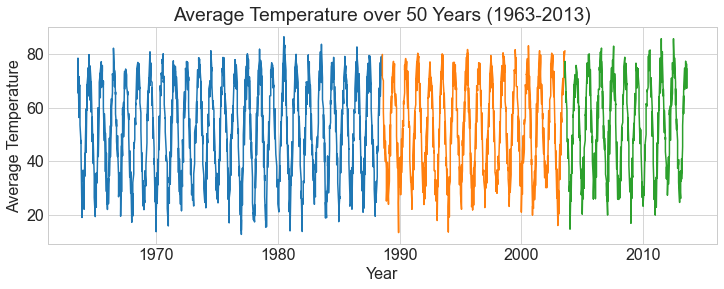

In [10]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel('Average Temperature')
    plt.xlabel('Year')
    plt.title('Average Temperature over 50 Years (1963-2013)')
    plt.show()

####Explore

In [11]:
y = train.avg_temp
y.head()

date
1963-08-01                  65.42
1963-08-01                  72.98
1963-08-01                  78.45
1963-09-01                  56.28
1963-09-01                  71.52
Name: avg_temp, dtype: float64

<AxesSubplot:ylabel='Frequency'>

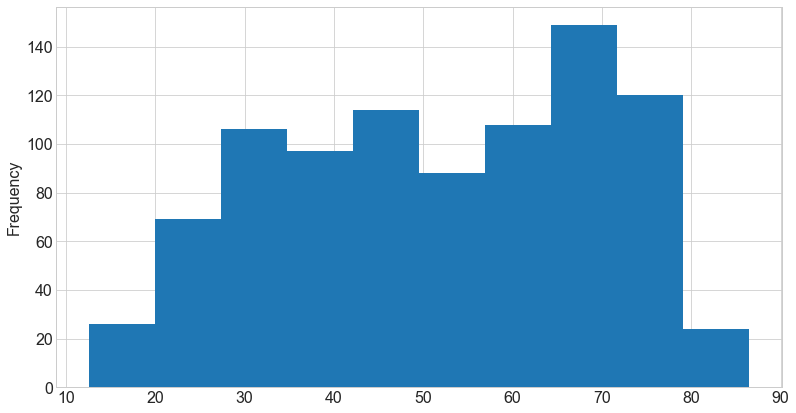

In [12]:
y.plot.hist()

[Text(0.5, 1.0, 'Average Temperature by Year'),
 Text(0.5, 0, 'Year (train)'),
 Text(0, 0.5, 'Temp (F)')]

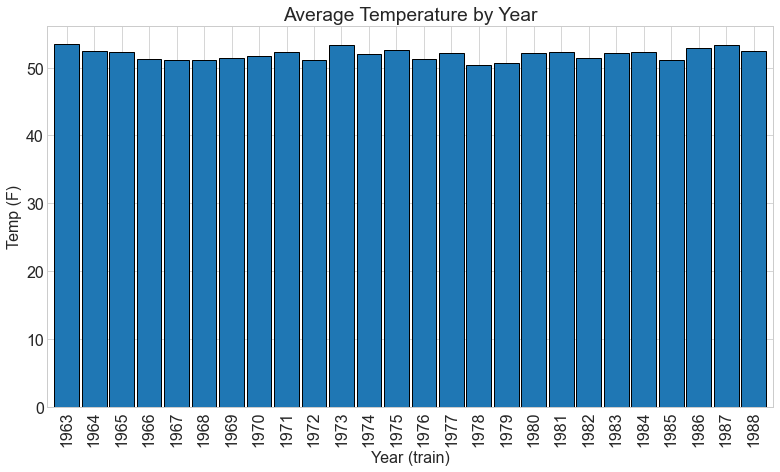

In [13]:
#Average temperature by year
ax = y.groupby(y.index.year).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=90)
ax.set(title='Average Temperature by Year', xlabel='Year (train)', ylabel='Temp (F)')

[Text(0.5, 1.0, 'Average Temperature by Month'),
 Text(0.5, 0, 'Month (train)'),
 Text(0, 0.5, 'Temp (F)')]

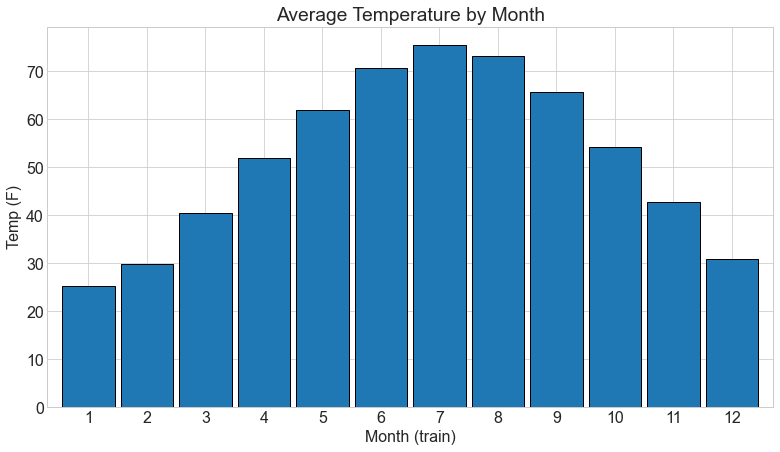

In [14]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Month', xlabel='Month (train)', ylabel='Temp (F)')

<AxesSubplot:xlabel='Year (train)', ylabel='Average Temperature'>

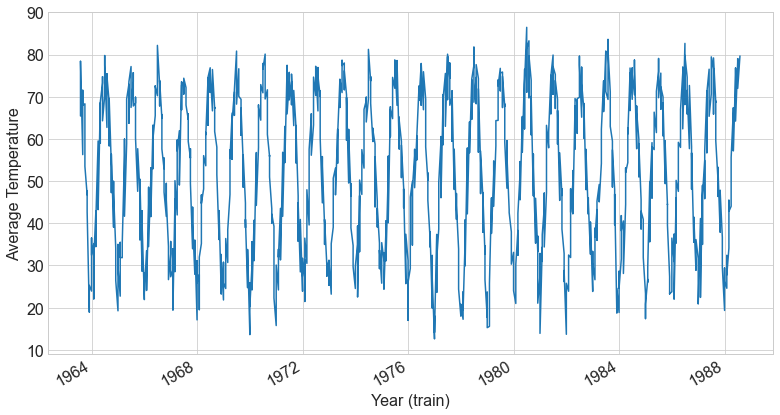

In [15]:
y.plot(xlabel = 'Year (train)', ylabel = 'Average Temperature')

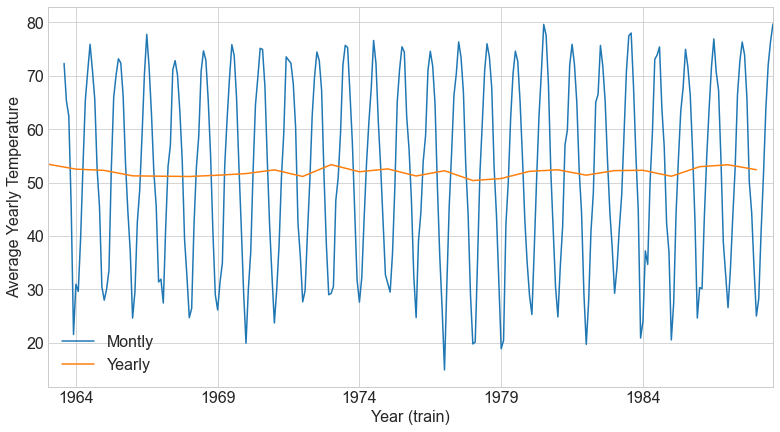

In [16]:
y.resample('M').mean().plot( label='Montly')
y.resample('Y').mean().plot(xlabel = 'Year (train)', ylabel = "Average Yearly Temperature", label='Yearly')
plt.legend()

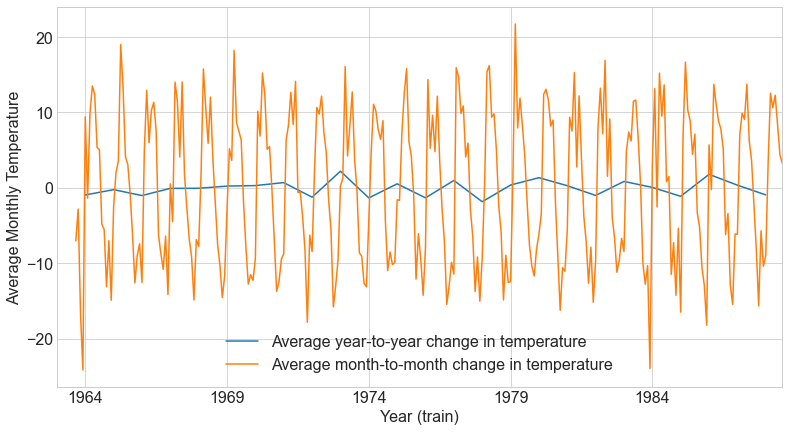

In [17]:
y.resample('Y').mean().diff().plot(label='Average year-to-year change in temperature')
y.resample('M').mean().diff().plot(xlabel = 'Year (train)', ylabel = 'Average Monthly Temperature', label='Average month-to-month change in temperature')
plt.legend()

<AxesSubplot:title={'center':'Seasonal Plot'}, xlabel='Month', ylabel='Temperature'>

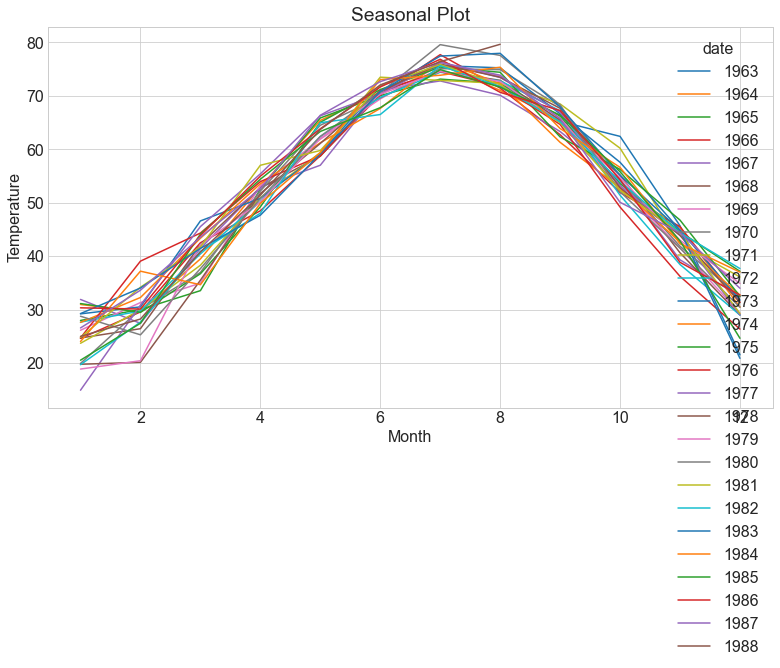

In [18]:
# .unstack turns an index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(xlabel = 'Month', ylabel = 'Temperature' ,title='Seasonal Plot')


Text(0.5, 1.0, 'Lag plot with lag=1')

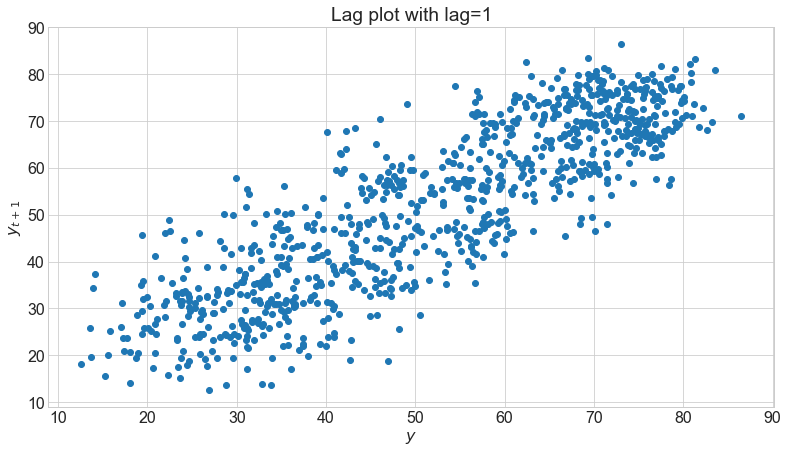

In [19]:
plt.scatter(y, y.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')

[Text(0.5, 0, 't'), Text(0, 0.5, 't + 1')]

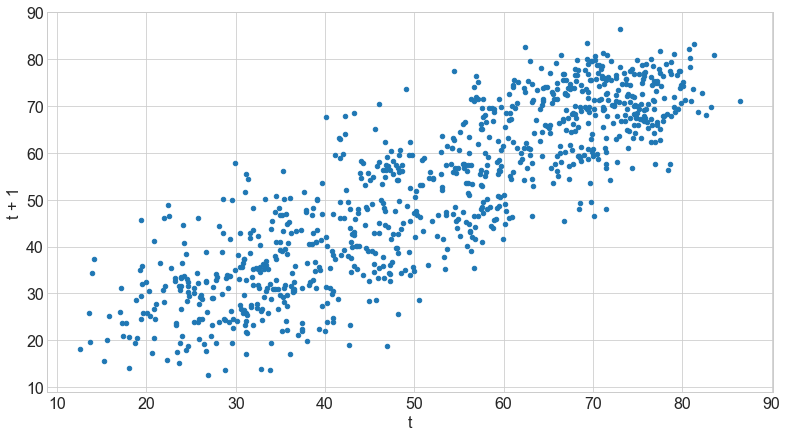

In [20]:
train['y(t + 1)'] = train.avg_temp.shift(-1)
ax = train.plot.scatter(x='avg_temp', y='y(t + 1)')
ax.set(xlabel='t', ylabel='t + 1')

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 26)'>

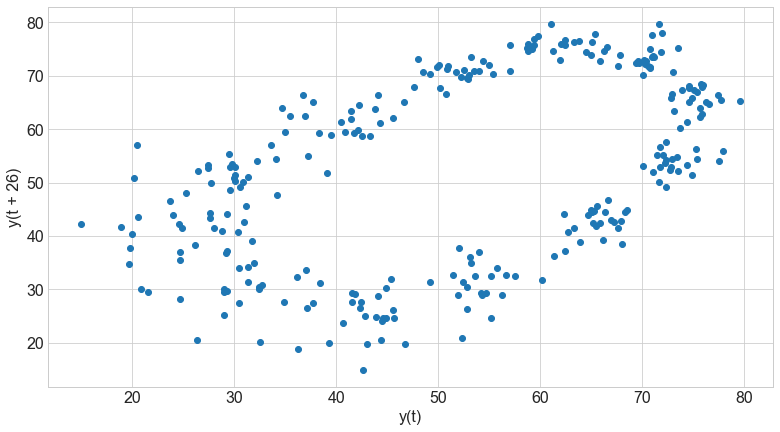

In [21]:
pd.plotting.lag_plot(train.avg_temp.resample('M').mean(), lag=26)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 52)'>

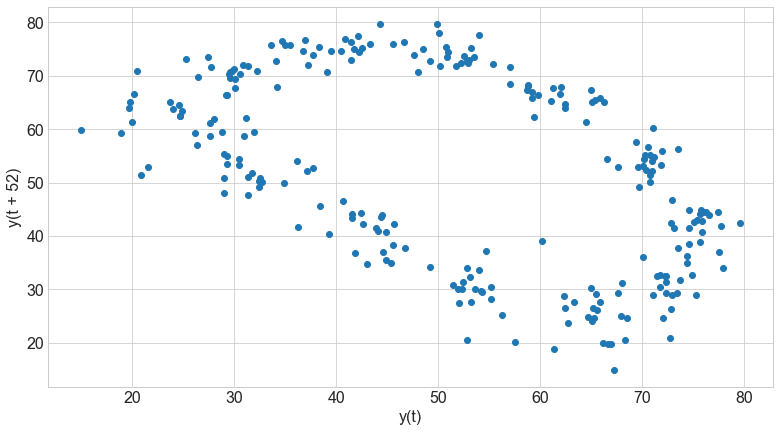

In [22]:
pd.plotting.lag_plot(train.avg_temp.resample('M').mean(), lag=52)

In [23]:
del train['y(t + 1)']

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

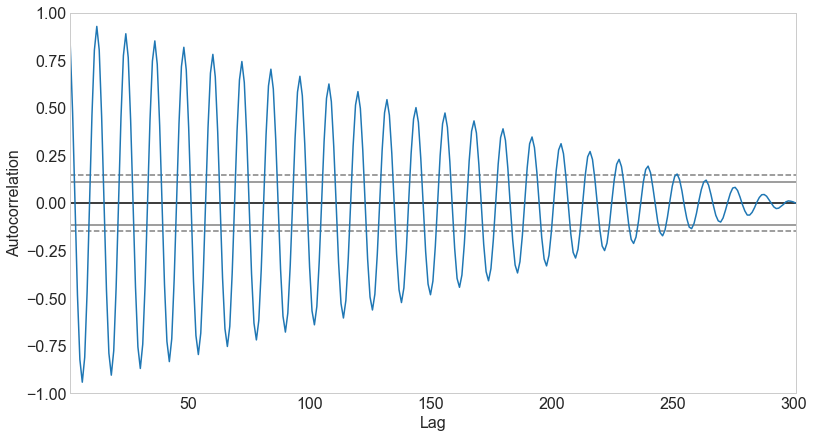

In [24]:
pd.plotting.autocorrelation_plot(train.avg_temp.resample('M').mean())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

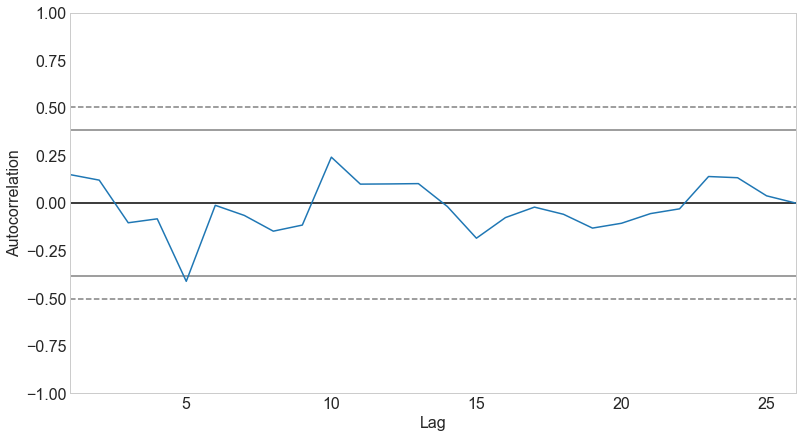

In [25]:
pd.plotting.autocorrelation_plot(train.avg_temp.resample('Y').mean())

In [26]:
y = train.avg_temp.resample('M').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

,y,trend,seasonal,resid
date,,,,
1963-08-31,72.28,NaN,21.32,NaN
1963-09-30,65.25,NaN,13.87,NaN
1963-10-31,62.43,NaN,2.04,NaN
1963-11-30,45.70,NaN,-9.13,NaN
1963-12-31,21.55,NaN,-20.47,NaN


<AxesSubplot:xlabel='Year', ylabel='Temperature'>

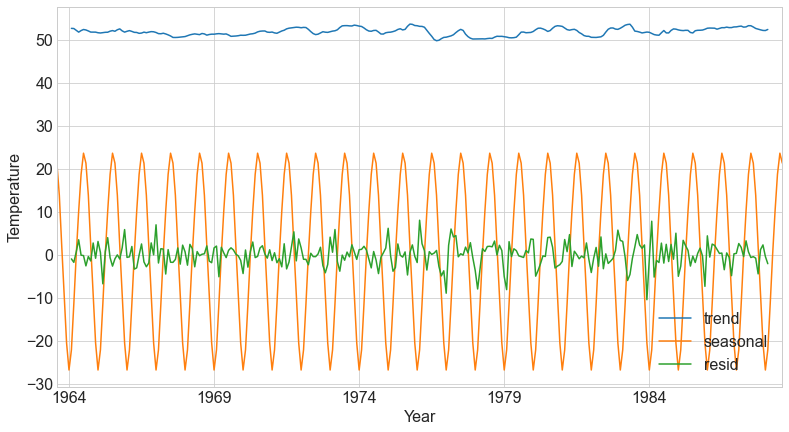

In [27]:
decomposition.iloc[:, 1:].plot(xlabel='Year', ylabel = 'Temperature')

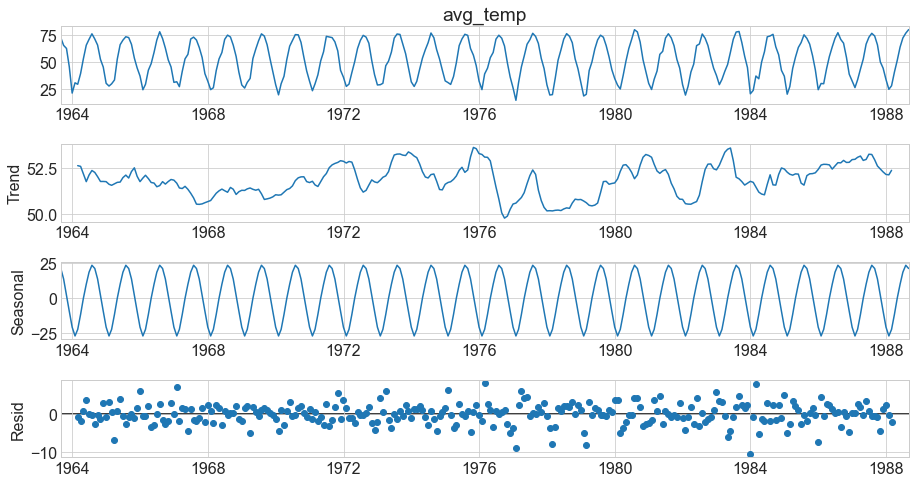

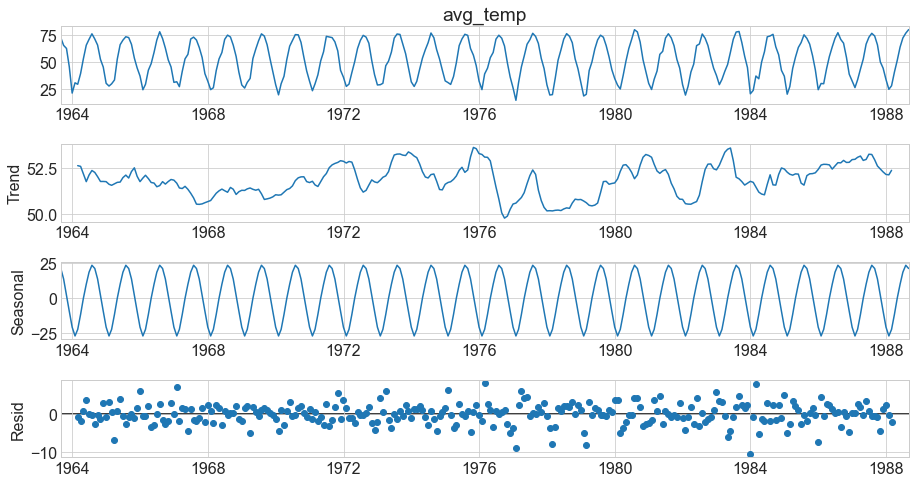

In [28]:
result.plot()

## USE HEAT MAP here

In [29]:
train = train.resample('M').mean()
# create a categorical feature
train['avgtemp_bin'] = pd.qcut(train.avg_temp, 4, labels=['cold', 'cool', 'warm', 'hot'])
train.groupby('avgtemp_bin').mean()

,avg_temp
avgtemp_bin,
cold,28.63
cool,45.17
warm,61.13
hot,73.29


In [30]:
validate = validate.resample('M').mean()

In [31]:
del train['avgtemp_bin']

####Model

In [32]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [33]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [34]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [35]:
eval_df

,model_type,target_var,rmse


# Forecast

#### Last observed value

In [36]:
avgtemp = train['avg_temp'][-1:][0]

yhat_df = pd.DataFrame({'avg_temp': [avgtemp]}, index = validate.index)

yhat_df.head(2)

,avg_temp
date,
1988-08-31,79.66
1988-09-30,79.66


avg_temp -- RMSE: 32


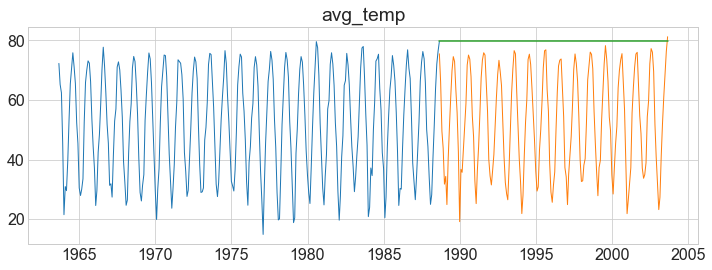

In [37]:
#Plot Actual vs. Predicted Values
for col in train.columns:
    plot_and_eval(col)

In [38]:
#Evaluate
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', target_var = col)

In [39]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,32.00


### Simple Average

In [40]:
#Make predictions
avgtemp = round(train['avg_temp'].mean(),2)

def make_predictions():
    yhat_df = pd.DataFrame({'avg_temp': [avgtemp]}, index = validate.index)
    return yhat_df

yhat_df = make_predictions()

In [41]:
yhat_df.head(2)

,avg_temp
date,
1988-08-31,51.98
1988-09-30,51.98


avg_temp -- RMSE: 17


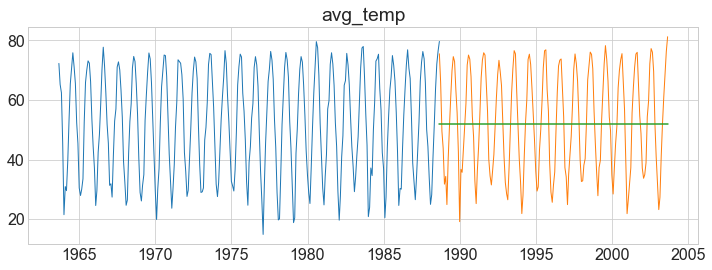

In [42]:
#Plot Actual vs. Predicted Values
for col in train.columns:
    plot_and_eval(col)

In [43]:
#Evaluate
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [44]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,32.00
1,simple_average,avg_temp,17.00


## Moving Average

In [45]:
#Make Predictions
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 3

avgtemp = round(train['avg_temp'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df.head(3)

,avg_temp
date,
1988-08-31,76.04
1988-09-30,76.04
1988-10-31,76.04


avg_temp -- RMSE: 29


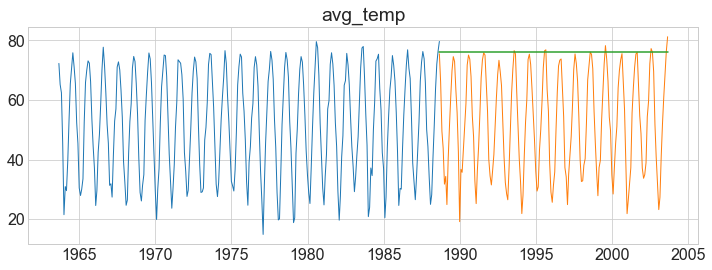

In [46]:
#Plot Actual vs. Predicted Values
for col in train.columns:
    plot_and_eval(col)

In [47]:
for col in train.columns:
    eval_df = append_eval_df(model_type='3 month moving average', 
                             target_var = col)

In [48]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,32.00
1,simple_average,avg_temp,17.00
2,3 month moving average,avg_temp,29.00


## Holt's Linear Trend

avg_temp 



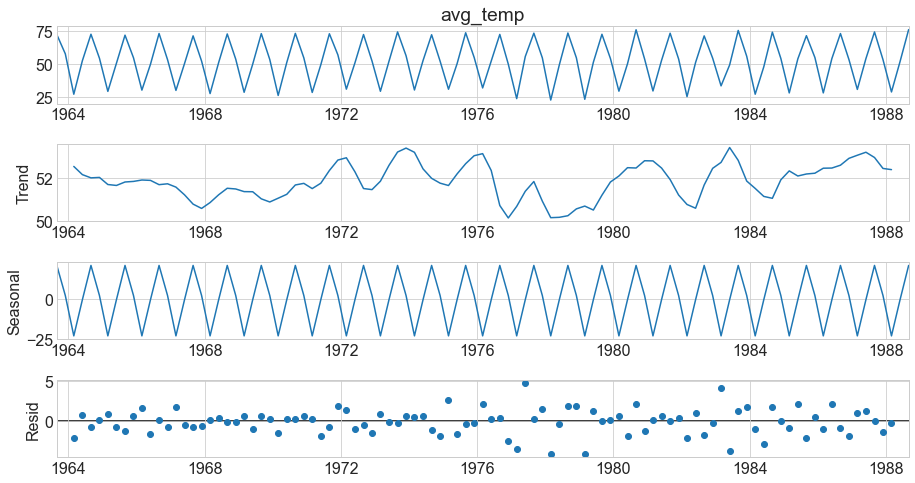

In [49]:
#look at the seasonal decomposition for each target
for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('3M').mean()).plot()
    plt.show()

In [50]:
#Make Predictions
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

avg_temp -- RMSE: 50


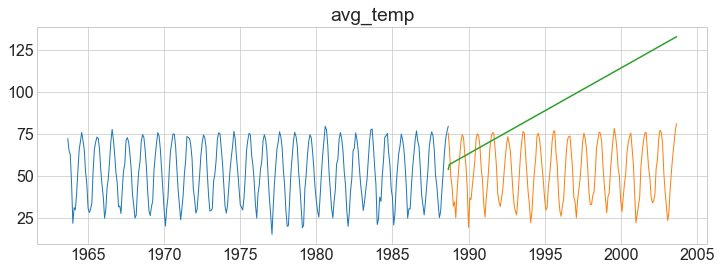

In [51]:
#Plot Actual vs. Predicted Values
for col in train.columns:
    plot_and_eval(target_var = col)

In [52]:
#Evaluate
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)

In [53]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,32.00
1,simple_average,avg_temp,17.00
2,3 month moving average,avg_temp,29.00
3,Holts,avg_temp,50.00


#### Predict Based on Previous Cycle

In [54]:
#Re-split data
train = df['2008':'2010']
validate = df['2011']
test = df['2012']

In [55]:
#Make Predictions
yhat_df = train['2008'] + train.diff(36).mean()

In [56]:
pd.concat([yhat_df.head(1), validate.head(1)])

,avg_temp
date,
2008-01-01,30.87
2011-01-01,19.81


avg_temp -- RMSE: 6


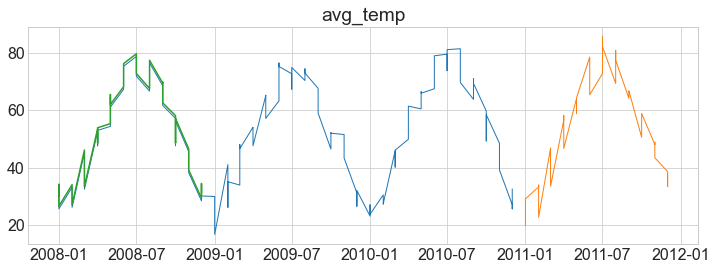

In [57]:
#Plot and Evaluate
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

### Best Model

Which model did the best? Then test to that model.

In [58]:
# get the min rmse for each variable

min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[0]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[(eval_df.rmse == min_rmse_items_sold)]

,model_type,target_var,rmse
4,previous year,avg_temp,6.00


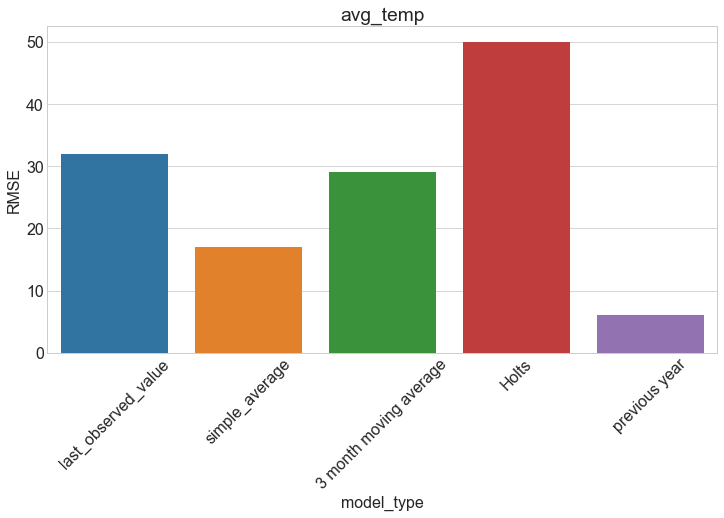

In [59]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

In [60]:
#Out of sample We will be using train + validate to predict test
yhat_df = validate + train.diff(36).mean()
yhat_df.index = test.index

In [61]:
rmse_avgtemp = round(sqrt(mean_squared_error(test['avg_temp'], yhat_df['avg_temp'])), 0)

In [62]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 5)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.show()

rmse - avgtemp:  8.0


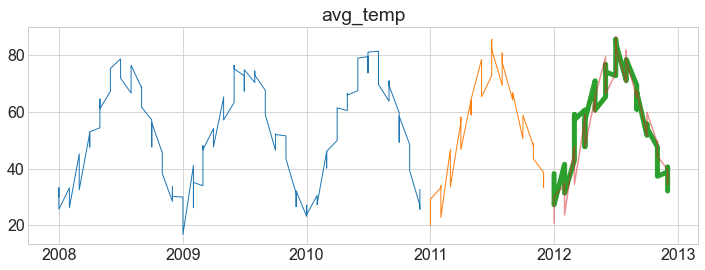

In [63]:
print("rmse - avgtemp: ", rmse_avgtemp)

for col in train.columns:
    plot_and_eval(col)

In [64]:
test.head()

,avg_temp
date,
2012-01-01,38.24
2012-01-01,33.85
2012-01-01,27.24
2012-02-01,41.51
2012-02-01,38.06


# Prediction beyond 2013

In [88]:
len(test)

36

In [92]:
df = pd.DataFrame({'date': pd.date_range(datetime(2014, 1, 1), datetime(2017, 1, 1), freq='M')}).set_index('date').sort_index()

In [93]:
df.head()

""
date
2014-01-31
2014-02-28
2014-03-31
2014-04-30
2014-05-31


In [94]:
print('Date Range:', df.index.min(), 'to', df.index.max())

Date Range: 2014-01-31 00:00:00 to 2016-12-31 00:00:00


In [96]:
df.shape

(36, 0)

In [97]:
#Out of sample We will be using train + validate to predict test
yhat_df = test + train.diff(36).mean()


In [98]:
yhat_df = yhat_df.set_index(df.index)

In [99]:
yhat_df.head()

,avg_temp
date,
2014-01-31,39.17
2014-02-28,34.78
2014-03-31,28.17
2014-04-30,42.44
2014-05-31,38.99


In [102]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 5)
    plt.plot(yhat_df[target_var], alpha = .5, linewidth = 5)
    plt.title(target_var)
    plt.show()

rmse - avgtemp:  8.0


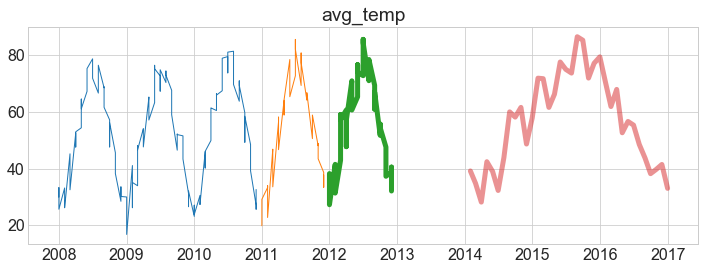

In [103]:
print("rmse - avgtemp: ", rmse_avgtemp)

for col in train.columns:
    plot_and_eval(col)